# Imports 

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

# Feature maps 

Get the data first: 

In [ ]:
import sys
import os
src_path = os.path.abspath('../../src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
from feature_maps import RecenterBondLayer
from diffusion_map import DiffusionMap
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load butane metadynamics data
# Note: Ensure the path is correct relative to your notebook's location.
metad_data_path = '../data/butane_nonaligned.npz' 
metad_data = np.load(metad_data_path)
data_all_atom = metad_data['data'][::10]
dihedrals = metad_data['dihedrals'][::10]

print(f"Subsampled data shape: {data_all_atom.shape}")

Subsampled data shape: (10000, 12)


Now featurize it with the group invariant map: 

In [5]:
bond_align_23 = RecenterBondLayer(atom_ind=[1, 2], batch_mode=True)
feature_mapped_data = bond_align_23(torch.tensor(data_all_atom, dtype=torch.float32))
feature_mapped_data_np = feature_mapped_data.detach().numpy()

Compute a diffusion map: 

In [19]:
dmap = DiffusionMap(alpha=1.0, num_evecs=4, epsilon=50.0)
dmap.construct_generator(feature_mapped_data_np.T)
L = dmap.L
diff_map, evecs, evals = dmap._construct_diffusion_coords(L)

done with kernel!
computing eigvec matrix


Visualize: 

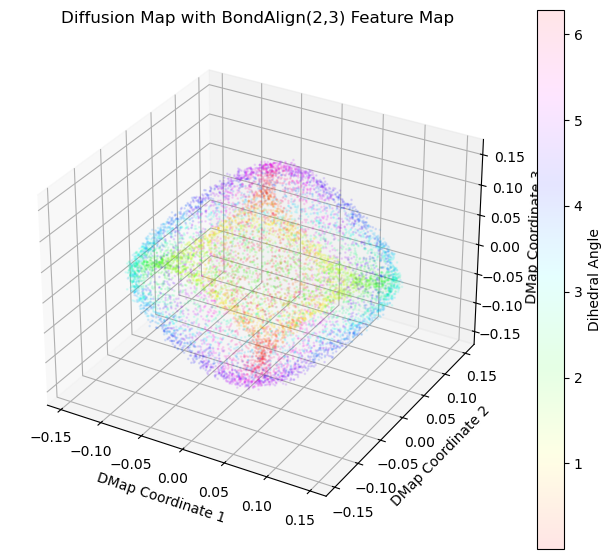

In [20]:
# Visualize the diffusion map coordinates
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(diff_map[:, 0], diff_map[:, 1], diff_map[:, 2], c=dihedrals, cmap='hsv', alpha=0.1, s=1)
ax.set_title('Diffusion Map with BondAlign(2,3) Feature Map')
ax.set_xlabel('DMap Coordinate 1')
ax.set_ylabel('DMap Coordinate 2')
ax.set_zlabel('DMap Coordinate 3')
fig.colorbar(sc, ax=ax, label='Dihedral Angle')

plt.show()

# Setting up data, architecture, optimizer

First, let's pack the data, Laplacian, and eigenvectors into a dataloader. 

In [41]:
from _dnet_datasets import *
dnet_dataset = DnetData(
    featurized_data=feature_mapped_data_np,
    diff_map=diff_map,
    laplacian=L.toarray(),
    eigvals=evals
)

In [42]:
train_loader = dnet_dataloader(dnet_dataset, batch_size=100)

Pull a batch, just to make sure stuff worked: 

In [62]:
batch = next(iter(train_loader))
batch[-1].shape

torch.Size([1024, 4])

In [63]:
batch[-1]

tensor([[-0.0192, -0.0192, -0.0193, -0.0193],
        [-0.0192, -0.0192, -0.0193, -0.0193],
        [-0.0192, -0.0192, -0.0193, -0.0193],
        ...,
        [-0.0192, -0.0192, -0.0193, -0.0193],
        [-0.0192, -0.0192, -0.0193, -0.0193],
        [-0.0192, -0.0192, -0.0193, -0.0193]], dtype=torch.float64)

Next, we define the model architecture: 

In [44]:
from _dnet_architectures import *
model_encoder_reg = standard_4_layer_dnet_tanh_encoder(input_dim=12, encoder_dim=4)
model_decoder_reg = standard_4_layer_dnet_tanh_decoder(input_dim=12, encoder_dim=4)

Finally, define the losses and the optimizer: 

In [45]:
loss_function = nn.MSELoss()
optimizer_reg_dec = optim.Adam(model_decoder_reg.parameters(), lr=1e-4, weight_decay = 1e-5)
optimizer_reg_enc = optim.Adam(model_encoder_reg.parameters(), lr = 1e-4, weight_decay=1e-5)

A training loop: 

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_sep(model_enc, model_dec, optimizer_enc, optimizer_dec, epoch, train_loader,verbose=False): # training for regular autoencoder
    model_enc.train()
    model_dec.train()
    loss1 = 0 # loss associated with the encoder
    loss2 = 0 
    loss3 = 0 
    loss4 = 0 # loss associated with the decoder
    
    # training loop
    for batch_idx, (indices, features, diff_map, Ltorch, eigvals_mat) in enumerate(train_loader):
        # data = data.to(device)
        diff_map = diff_map.to(device)
        features = features.to(device)
        Ltorch = Ltorch.to(device)
        eigvals_mat = eigvals_mat.to(device)
        features.requires_grad_(True)
        encoded_data = model_enc(features.float()) 
        decoded_data = model_dec(encoded_data)

        optimizer_enc.zero_grad() 
        optimizer_dec.zero_grad()
        
        # loss_tmd = loss_function(encoded_data, diff_map.float())
        jacobians = []
        for i in range(2):
            jj = torch.autograd.grad(encoded_data[:,i].sum(), features, create_graph=True)[0]
            jacobians.append(jj)
        inner_prods = torch.sum(jacobians[0]*jacobians[1], dim=1)
        loss_tmd = loss_function(inner_prods, torch.zeros_like(inner_prods))
        loss_dec = loss_function(decoded_data, features.float())
        loss_eigs = torch.mean((torch.matmul(Ltorch.float(), encoded_data.float())-\
                     encoded_data.float()*eigvals_mat.float())**2)

        loss_enc = 10.0*loss_tmd + 0.5*loss_eigs

        loss_total = loss_enc + loss_dec
        # loss_enc.backward(retain_graph=True)
        # loss_dec.backward()
        loss_total.backward(retain_graph = True)
        optimizer_enc.step()
        optimizer_dec.step()
        loss1 += loss_tmd.item()
        loss2 += loss_eigs.item()
        loss3 += loss_enc.item()
        loss4 += loss_dec.item()
    if verbose:
        print(f'====> Average loss: {loss1:.4f}, {loss2:.4f}, {loss3:.4f}')
        print('====> Average decoder loss: {:.4f}'.format(
             loss4 / len(train_loader.dataset)))

# Training the LAPCAE

Training: 

In [65]:
num_epochs = 500
train = True
if train:
    for epoch in tqdm(range(num_epochs)):
        # print(f"epoch {epoch}:")
        if epoch % 50 == 0:
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, True)
        else: 
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, False)

  0%|          | 1/500 [00:02<20:48,  2.50s/it]

====> Average loss: 0.0000, 0.0000, 0.0000
====> Average decoder loss: 0.0011


 10%|█         | 51/500 [00:26<03:55,  1.91it/s]

====> Average loss: 0.0000, 0.0000, 0.0000
====> Average decoder loss: 0.0003


 20%|██        | 101/500 [00:48<02:56,  2.26it/s]

====> Average loss: 0.0000, 0.0000, 0.0000
====> Average decoder loss: 0.0003


 30%|███       | 151/500 [01:17<02:41,  2.16it/s]

====> Average loss: 0.0000, 0.0000, 0.0001
====> Average decoder loss: 0.0003


 40%|████      | 201/500 [01:41<02:15,  2.21it/s]

====> Average loss: 0.0002, 0.0000, 0.0017
====> Average decoder loss: 0.0003


 50%|█████     | 251/500 [02:03<01:49,  2.28it/s]

====> Average loss: 0.0001, 0.0000, 0.0014
====> Average decoder loss: 0.0002


 60%|██████    | 301/500 [02:30<01:26,  2.31it/s]

====> Average loss: 0.0001, 0.0000, 0.0014
====> Average decoder loss: 0.0001


 70%|███████   | 351/500 [02:52<01:06,  2.24it/s]

====> Average loss: 0.0000, 0.0000, 0.0003
====> Average decoder loss: 0.0001


 80%|████████  | 401/500 [03:14<00:45,  2.16it/s]

====> Average loss: 0.0001, 0.0000, 0.0009
====> Average decoder loss: 0.0001


 90%|█████████ | 451/500 [03:40<00:21,  2.27it/s]

====> Average loss: 0.0001, 0.0000, 0.0005
====> Average decoder loss: 0.0000


100%|██████████| 500/500 [04:02<00:00,  2.07it/s]


# Evaluate the model

In [69]:
diffusion_net_data = model_encoder_reg(feature_mapped_data.float()).detach().numpy()

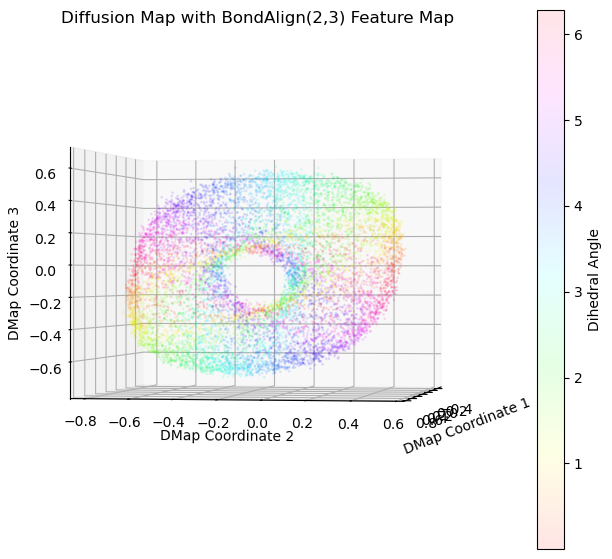

In [73]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(diffusion_net_data[:,0], diffusion_net_data[:,1], diffusion_net_data[:,2], c=dihedrals, cmap='hsv', alpha=0.1, s=1)
ax.set_title('Diffusion Map with BondAlign(2,3) Feature Map')
ax.set_xlabel('DMap Coordinate 1')
ax.set_ylabel('DMap Coordinate 2')
ax.set_zlabel('DMap Coordinate 3')
fig.colorbar(sc, ax=ax, label='Dihedral Angle')
ax.view_init(elev=0, azim=10)
plt.show()

# Save model 

In [76]:
torch.save(model_encoder_reg.state_dict(), '../outputs/bondalign_23/LAPCAE_encoder_trial.pth')
torch.save(model_decoder_reg.state_dict(), '../outputs/bondalign_23/LAPCAE_decoder_trial.pth')

In [75]:
os.getcwd()

'/Users/shashanksule/Documents/CV_learning/learn/manifold_learning'